In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import invgamma
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv')
mat = data.values

In [22]:
timesteps, nodes = mat.shape
node_numbers = []
for i in range(10,90):
    node_numbers.append(i)
dx = 1e-2
dt = 1e-3

def library_and_y(node_numbers):
    X = None
    y = None
    for p in node_numbers:
        b = np.ones(timesteps)
        d = mat[:,p]
        d1 = (mat[:,p+1] - mat[:,p-1])/(2*dx)
        d2 = (mat[:,p+1] + mat[:,p-1] - 2*mat[:,p])/dx**2
        d3 = (mat[:,p+2] - 2*mat[:,p+1] + 2*mat[:,p-1] - mat[:,p-2])/(2*dx**3)
        d4 = (mat[:,p+2] - 4*mat[:,p+1] + 6*mat[:,p] - 4*mat[:,p-1] + mat[:,p-2] )/dx**4
        # d5 = (mat[:,p+3] - 2*mat[:,p+2] + 3*mat[:,p+1] - 3*mat[:,p-1] + 2*mat[:,p-2] -
        #       mat[:,p-3])/(2*dx**5)
        d5 = (mat[:,p+3] - 5*mat[:,p+2] + 10*mat[:,p+1] - 10*mat[:,p-1] + 5*mat[:,p-2] - mat[:,p-3]) / (2*dx**5)

        d6 = (mat[:,p+3] - 6*mat[:,p+2] + 15*mat[:,p+1] - 20*mat[:,p] + 15*mat[:,p-1] -
              6*mat[:,p-2] + mat[:,p-3])/(dx**6)

        dcos = np.cos(d)
        dsin = np.sin(d)

        dt2 = np.ones(timesteps)
        dt1 = np.ones(timesteps)
        
        for i in range(1,timesteps-1):
          dt2[i] = (mat[i+1,p] + mat[i-1,p] - 2*mat[i,p])/dt**2
          dt1[i] = (mat[i+1,p] - mat[i-1,p] )/(2*dt)
        temp = np.vstack((d, d1, d2, d3, d4, d5, d6, d*d1, d*d2, d*d3, d*d4 , d*d5, d*d6,
               d1*d2, d2*d3, d3*d4, d4*d5, d5*d6, dcos, dsin, d1*d3, d3*d5, d2*d4,
               d1*d4, d2*d5, d3*d6, dcos*d1, dsin*d1, dsin*d4,d**2)).T[1:-1]
#         temp = np.vstack((b,d1,d2,d3,d4,d*d1,d*d2,d*d3)).T[1:-1]
        if X is None:
            X = temp
        else:
            X = np.vstack((X,temp))
        if y is None:
            y = dt2[1:-1]
        else:
            y = np.hstack((y,dt2[1:-1]))
    return X,y


# X = np.vstack((b,d4,d4*d1)).T
X,y = library_and_y(node_numbers)
scaler = StandardScaler()
# X = scaler.fit_transform(X)

np.set_printoptions(threshold = np.inf)
X = X[10:-10:10,:]
y = y[10:-10:10]

correlation_matrix = np.corrcoef(X, rowvar=False)
high_correlation_threshold = 0.9
features_to_remove = set()
highly_correlated_pairs = []
feature_names = ['d', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd*d1', 'd*d2', 'd*d3', 'd*d4', 'd*d5', 'd*d6',
                 'd1*d2', 'd2*d3', 'd3*d4', 'd4*d5', 'd5*d6', 'dcos', 'dsin', 'd1*d3', 'd3*d5', 'd2*d4',
                 'd1*d4', 'd2*d5', 'd3*d6', 'dcos*d1', 'dsin*d1', 'dsin*d4', 'd**2']
d4_index = feature_names.index('d4')
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix[i, j]) > high_correlation_threshold:
            if i == d4_index:
                features_to_remove.add(j)
                highly_correlated_pairs.append((feature_names[i], feature_names[j]))
            elif j == d4_index:
                features_to_remove.add(i)
                highly_correlated_pairs.append((feature_names[i], feature_names[j]))
            else:
                features_to_remove.add(j)
                highly_correlated_pairs.append((feature_names[i], feature_names[j]))
features_kept_indices = [i for i in range(len(feature_names)) if i not in features_to_remove]
features_kept = [feature_names[i] for i in features_kept_indices]
X = np.delete(X, list(features_to_remove), axis=1)
print(features_kept)
d4_index = features_kept.index('d4')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X= X_train
y = y_train

N = len(y)
K = np.size(X,1)

# Number of samples
iter = 10000

# Compute values which does not change with iterations and is function of Dataset
L2 = X.T @ X
Ly = X.T @ y
y2 = y.T @ y
print(X.shape)

print(np.linalg.det(L2))
print(np.linalg.cond(L2))

['d2', 'd4', 'd*d1', 'd*d2', 'd*d3', 'd1*d2', 'd2*d3']
(12785, 7)
5.851792368277344e+30
274085.3705858164


In [23]:

#Initializing parameters
theta = [np.zeros(K)]
theta[-1][d4_index] = -1
sigma = [np.random.rand(1)+1.5] 
tau = [np.random.rand(1)+1.5]
lamda = [np.random.rand(K)+1.5]
gamma  = [np.random.rand(1)+1.5]
zeta = [np.random.rand(K)+.5]

#Initialize hyperparameters
alpha = 1
beta = 1e-4
eta = 3
tau0 = 2


for i in range(1,iter):

  # if i>=1 and i <20:
  #   print(i)
  #   print(f"Value of tau is {tau[-1]}")
  #   print(f"Value of gamma is {gamma[-1]}")
  #   print(f"Value of mu is {np.linalg.norm(mu)}")

  #   print(f"Value of cov is {np.linalg.det(cov)}")
  #   print(f"Value of sigma is {sigma[-1]}")

  z = 1/lamda[-1]
  A = np.diag(z.flatten())
  inv_cov =  L2/sigma[-1] + A/tau[-1]
  cov = np.linalg.inv(inv_cov)
  mu = np.dot(cov,Ly/sigma[-1])
  theta.append(np.random.multivariate_normal(mu, cov))

  # sample sigma^2
  al = N/2 + alpha
  be = 0.5*((y- X@theta[-1]).T @ (y- X@theta[-1])) + beta
  si = invgamma.rvs(al,be)
  sigma.append(si)

  #sample tau^2
  al1 = (K+eta)/2
  be1 =  0.5*(theta[-1].T @ ( A @ theta[-1])) + eta/gamma[-1]
  ta = invgamma.rvs(al1,be1)
  tau.append(ta)

  # sample lamda
  x = []
  t = np.linalg.norm(theta[-1])**2
  al =(eta +1)/2
  for i in range(K):
    be = (theta[-1][i])**2/(2*tau[-1]) + eta/zeta[-1][i]
    la = invgamma.rvs(al,be)
    x.append(la)
  lamda.append(np.array(x))
  a= np.linalg.norm(lamda[-1])

  #sample gamma
  al = (eta+1)/2
  be = 1/(tau0**2) + eta/tau[-1]
  ga = invgamma.rvs(al,be)
  gamma.append(ga)

  #sample zeta
  x = []
  al = (eta+1)/2
  for i in range(K):
    be = 1 + (eta/lamda[-1][i])
    ze = invgamma.rvs(al,be)
    x.append(ze)
  zeta.append(np.array(x))

theta = np.array(theta)
print(theta.shape)
t = np.mean(theta[2000:10000,:],0)
y_calc = np.dot(X_test,t.T)
err= np.linalg.norm(y_test - y_calc)/N
print("Error value is " + str(err))
mean = np.mean(y)
print("Mean y value is " + str(mean))
print("Theta:")
print(t)

C:\Users\harsh\AppData\Local\Temp\ipykernel_6632\14474519.py:33: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  theta.append(np.random.multivariate_normal(mu, cov))
C:\Users\harsh\AppData\Local\Temp\ipykernel_6632\14474519.py:37: RuntimeWarning: overflow encountered in matmul
  be = 0.5*((y- X@theta[-1]).T @ (y- X@theta[-1])) + beta


LinAlgError: SVD did not converge

In [38]:
np.std(theta[2000:iter, :],0)

array([2.80633442, 0.94359637, 3.41845728, 4.74598622])

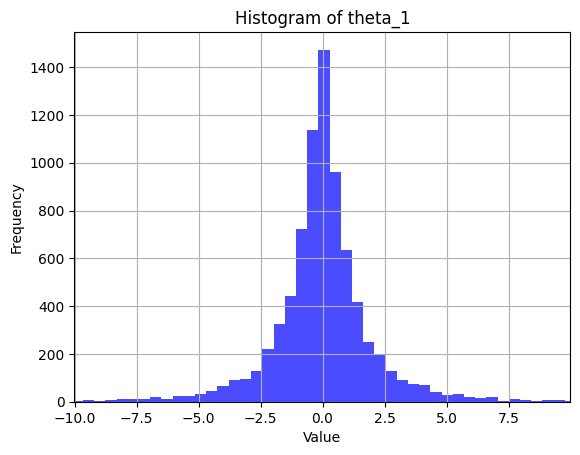

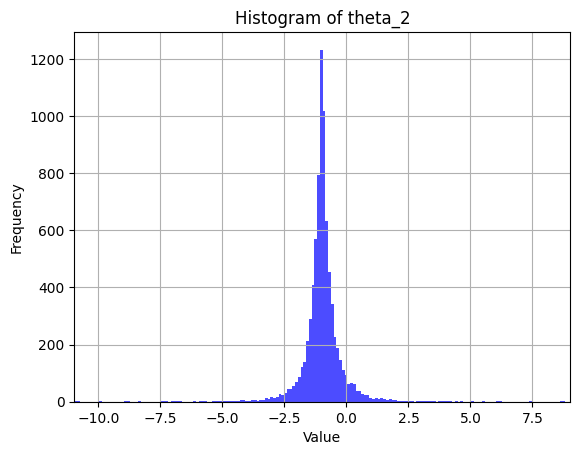

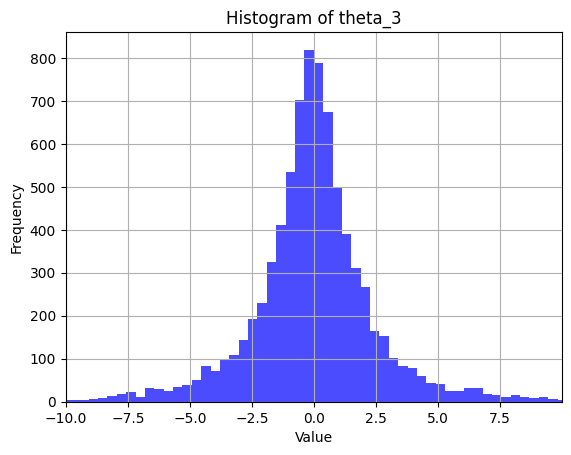

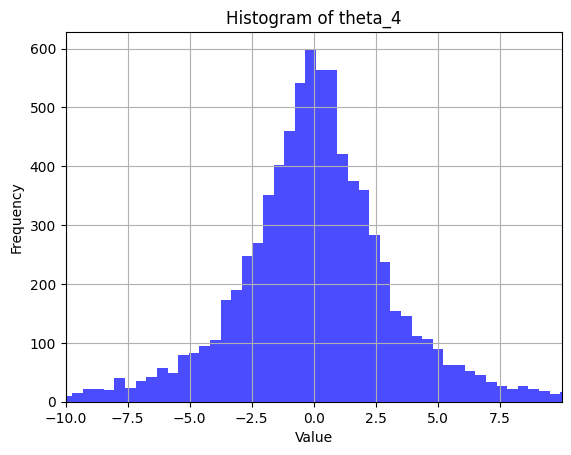

In [42]:

for i in range(4):
    data = theta[2000:iter , i]
    m = np.mean(data)
    plt.hist(data, bins=400, color='blue', alpha=0.7)
    plt.xlim(m-10, m+10) 
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of theta_{i+1}')
    plt.grid(True)
    plt.show()